# Background Model

Here we calculate the background model of Light-1 initially for a specific species and then for a the addition of the species in the atmosphere.

## Single Species

We will calculate the expected number of hits within a time $T$ on the satellite arizing from particle $\chi$. We know the following:

$$\bar{\Phi}_\chi (E) \vcentcolon = \mathbb{E}_\Phi \left[ f_\chi (\Phi, E)\right]$$
$$f_\chi (E) \vcentcolon = \frac{\bar{\Phi}_\chi (E)}{|| \bar{\Phi}_\chi (E) ||}$$

Where $E$ is the energy of the particle, $\Phi$ is the flux of the particle, $f_\chi (\Phi, E)$ is the probability distribution of finding a particular flux of particles $\chi$ with a specific energy $E$ in the atmosphere. 

Notice that we don't actually know the latter distribution, but we won't need to in order to proceed with the background model. All we need is the probability distribution of obtainining a particle with energy $E$ aka $f_\chi (E)$, and the average flux at that particular energy $\bar{\Phi}_\chi (E)$.

We also know that observing a particle is a poisson process. Since we know the expected flux of the particles we can find the probability of obtaining $n$ particles within time $T$ given that they have energy $\varepsilon$.

$$P(N=n \mid E=\varepsilon) = \frac{\lambda(\varepsilon) ^n}{n!} e^{-\lambda(\varepsilon)}$$

Where $\lambda(\varepsilon)$ is the expected rate of events given by

$$\lambda(\varepsilon) = \bar{\Phi}_\chi (\varepsilon) A_{\chi}(\varepsilon) T$$

where $A_{\chi}(\varepsilon)$ is the effective cross sectional area of the satellite for particle $\chi$. This depends on the energy as lower energy particles are more likely to not penetrate the outer layers and reach the detector. This parameter can be given by

$$A_\chi (\varepsilon) = A_{\text{cross}} P_{\chi}(\varepsilon)$$

wheere $A_{\text{cross}}$ is the cross sectional area of the detector, and $P_{\chi}(\varepsilon)$ is the probability that a particle $\chi$ with energy $\varepsilon$ will be thermalized in one of the detectors.

Finally the probability of obtaining $n$ events of species $\chi$ regardless of the energy is going to be:

$$P(N=n) = \int_{\mathbb{R}}d\varepsilon\ P(N=n \mid E=\varepsilon)\, f_\chi(\varepsilon)$$

## Calculation

In [26]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib widget

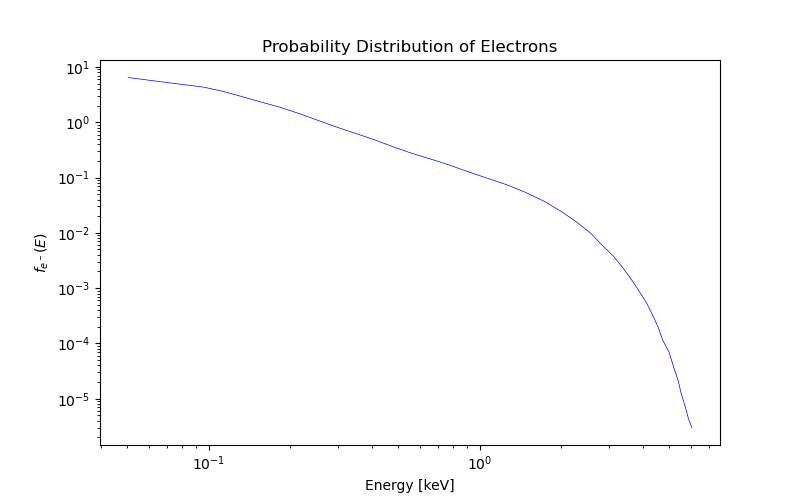

In [124]:
# Load the data 
flux_data = pd.read_csv('./data/Electrons.csv').to_numpy().T
electron  = {
    'energy':       flux_data[0],
    'flux':         flux_data[1],
    'distribution': flux_data[1]/np.sum(flux_data[1][:-1]*(flux_data[0][1:] - flux_data[0][:-1]))
}

# Set the threshold
THRESHOLD = 0.2 # keV

# Plot the energy distribution
plt.figure(figsize=(8,5))
plt.plot(electron['energy'],electron['distribution'],lw=0.5,c='blue')
plt.title('Probability Distribution of Electrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [keV]')
plt.ylabel(r'$f_{e^-}(E)$');

In [57]:
# Load the Geant4 Data
geant_data = pd.read_csv('./data/dump.txt',sep='*',header='infer')      # Load the data
geant_data.columns = geant_data.columns.str.strip()                     # Remove whitespace from the headers

# Show the data
geant_data

,Unnamed: 0,Row,Edep1,Edep2,Edep3,Edep4,e1s,e2s,e3s,e4s,eTOTs,nrgpri,EdepTOT,EdepVETO,EdepMomen,EdepAlbox,EdepEnclo,Unnamed: 17
0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289250,0.0,0.00000,0.0,0.0,0.289250,NaN
1,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050571,0.0,0.00000,0.0,0.0,0.050571,NaN
2,NaN,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096655,0.0,0.00000,0.0,0.0,0.096655,NaN
3,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089952,0.0,0.00000,0.0,0.0,0.032815,NaN
4,NaN,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056430,0.0,0.02955,0.0,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,NaN,999989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089222,0.0,0.00000,0.0,0.0,0.000000,NaN
999990,NaN,999990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390365,0.0,0.00000,0.0,0.0,0.000000,NaN
999991,NaN,999991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047246,0.0,0.00000,0.0,0.0,0.000000,NaN
999992,NaN,999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078145,0.0,0.00000,0.0,0.0,0.078145,NaN


(0.042958, 6.0560951)

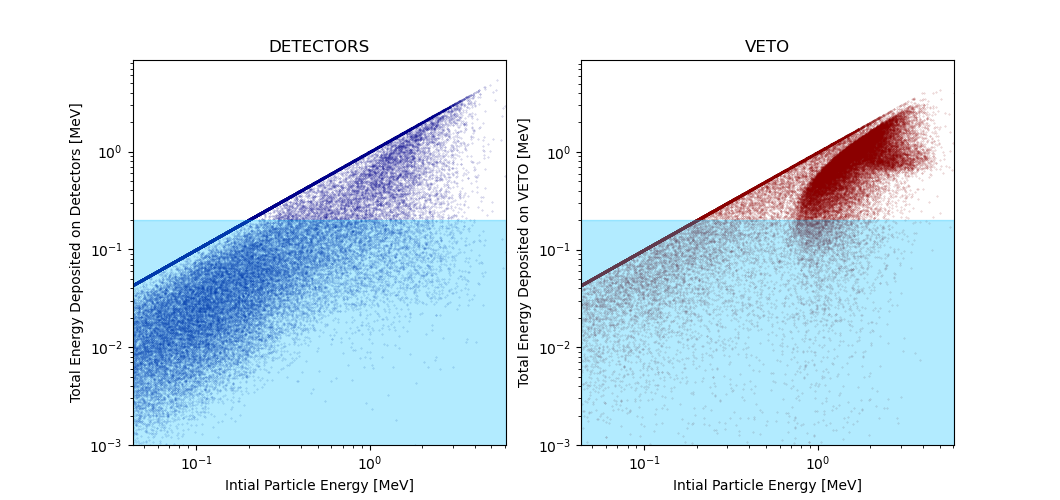

In [139]:
# Plot the total energy deposited as a function of the total initial energy
fig = plt.figure(figsize=(2*5.3,5))
ax  = [fig.add_subplot(121),fig.add_subplot(122)]
ax[0].scatter(geant_data['nrgpri'],geant_data['EdepTOT'],s=0.1,alpha=0.3,c='darkblue')
ax[0].fill_between([min(geant_data['nrgpri']),max(geant_data['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[0].set_xlabel('Intial Particle Energy [MeV]')
ax[0].set_ylabel('Total Energy Deposited on Detectors [MeV]')
ax[0].set_title('DETECTORS')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-3)
ax[0].set_xlim(min(geant_data['nrgpri']),max(geant_data['nrgpri']))

ax[1].scatter(geant_data['nrgpri'],geant_data['EdepVETO'],s=0.1,alpha=0.3,c='darkred')
ax[1].fill_between([min(geant_data['nrgpri']),max(geant_data['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[1].set_xlabel('Intial Particle Energy [MeV]')
ax[1].set_ylabel('Total Energy Deposited on VETO [MeV]')
ax[1].set_title('VETO')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3)
ax[1].set_xlim(min(geant_data['nrgpri']),max(geant_data['nrgpri']))

In [141]:
len(np.where(geant_data['EdepTOT']==0)[0])/len(geant_data['EdepTOT'])

0.9247625485752915